In [41]:
!pip install bertopic
!pip install -U sentence-transformers
!pip install -U kaleido

import kaleido
import sys
import os
import pandas as pd
import plotly.io as pio
import matplotlib.pyplot as plt
import umap

from bertopic import BERTopic
import numpy as np
from sklearn.manifold import TSNE

import seaborn as sns

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

import plotly.graph_objs as go

In [7]:
df_dubliners=pd.read_csv('Dubliners_James_Joyce.csv')
df_ulysses=pd.read_csv('Ulysses_James_Joyce.csv')
df_portrait=pd.read_csv('Portrait_James_Joyce.csv')

In [95]:
df_portrait=pd.read_csv('Portrait_James_Joyce.csv')

In [69]:
def process_file(df,sent_length,title):
    
    chapt=1
    begin=0
    end=sent_length
    
    text=df.iloc[0]['Text'].split()
    
    df_processed=pd.DataFrame(columns=['text','chapter','book'])
    
    while begin<=len(text):
        sent=text[begin:end]
        if 'CHAPTER_END' in sent:
            idx=sent.index('CHAPTER_END')
            if idx>0:
                df_processed.loc[len(df_processed)]=[' '.join(sent[:idx]),chapt,title]
                if idx<len(sent)-1:
                    chapt+=1
                    df_processed.loc[len(df_processed)]=[' '.join(sent[idx+1:]),chapt,title]
                elif idx==len(sent)-1:
                    chapt+=1
            elif idx==0:
                chapt+=1
                df_processed.loc[len(df_processed)]=[' '.join(sent[idx+1:]),chapt,title]
        else:
            df_processed.loc[len(df_processed)]=[' '.join(sent),chapt,title]
        begin+=sent_length
        end+=sent_length
        
    sent_vecs=model.encode(df_processed['text'].to_list())
    df_processed['embeddings']=pd.Series(list(sent_vecs))
    
    return df_processed
            
    

In [78]:
df_processed={}

df_processed['Ulysses']=process_file(df_ulysses,100,'Ulysses')
df_processed['Portrait']=process_file(df_portrait,100,'Portrait')
df_processed['Dubliners']=process_file(df_dubliners,100,'Dubliners')

In [96]:
df_processed['Portrait']=process_file(df_portrait,100,'Portrait')

In [79]:
df_processed['Ulysses'].to_csv('./data/df_processed_Ulysses')
df_processed['Portrait'].to_csv('./data/df_processed_Portrait')
df_processed['Dubliners'].to_csv('./data/df_processed_Dubliners')

In [98]:
def tsne_plot(df,title=None):
    tsne_vecs=TSNE(n_components=2).fit_transform(np.stack(df['embeddings']))
    #df_reduced=df_reduced.rename(columns={0:'x',1:'y'})
    #df_reduced=df_reduced.assign(label=df.chapter.values)
    
    colors=df.chapter.to_numpy()
    labels=colors

    trace = go.Scatter(
        x=tsne_vecs[:, 0],
        y=tsne_vecs[:, 1],
        text=labels,  # Specify the label for each point
        mode='markers',
        hoverinfo='text',  # Show label when hovering over a point
        marker=dict(
            size=4,
            color=colors,
            opacity=0.5,
            line=dict(width=0.5, color='white'),
            colorbar=dict(title='Colorbar Title')  # Add a color bar with title
        )
    )

    layout = go.Layout(
        title='TSNE Plot: '+title if title is not None else 'TSNE Plot',
        hovermode='closest',
        xaxis=dict(title='X axis'),
        yaxis=dict(title='Y axis')
    )

    # Create a Figure object and add the trace and layout
    fig = go.Figure(data=[trace], layout=layout)

    # Show the plot
    
    
    if title is not None:
        #fig.write_image(filename)
        pio.write_image(fig, './figures/tsne_'+title, format='png')
    fig.show()

def heatmap_plot(df,title=None):
    chapter_vecs=df.groupby('chapter')['embeddings'].sum().values
    
    norms=[np.sqrt(np.dot(chapter_vecs[i],chapter_vecs[i])) for i in range(len(chapter_vecs))]
    
    cos_distance= [[np.dot(chapter_vecs[i],chapter_vecs[j])/(norms[i]*norms[j]) \
                    for i in range(len(chapter_vecs))] for j in range(len(chapter_vecs))]
    
    
    last_chapter=max(df['chapter'])
    
    ax=sns.heatmap(cos_distance)
    
    ax.set_xlabel('Chapter')
    ax.set_ylabel('Chapter')
    
    if title is not None:
        ax.set_title('Heatmap: '+title if title is not None else 'Heatmap')
    ax.set_xticklabels(np.arange(1,last_chapter+1))
    ax.set_yticklabels(np.arange(1,last_chapter+1))
    
    if title is not None:
        plt.savefig('./figures/heatmap_'+title)
    plt.show()
    
    return cos_distance
    
def umap_plot(df,title=None):
    sent_vecs=list(df['embeddings'])
    umap_emb = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='euclidean').fit_transform(sent_vecs)
    
    colors=df.chapter.to_numpy()
    
    trace = go.Scatter(
        x=umap_emb[:, 0],
        y=umap_emb[:, 1],
        text=colors,  # Specify the label for each point
        mode='markers',
        hoverinfo='text',  # Show label when hovering over a point
        marker=dict(
            size=4,
            color=colors,
            opacity=0.5,
            line=dict(width=0.5, color='white'),
            colorbar=dict(title='Colorbar Title')  # Add a color bar with title
        )
    )

    layout = go.Layout(
        title='UMAP: '+title if title is not None else 'UMAP',
        hovermode='closest',
        xaxis=dict(title='X axis'),
        yaxis=dict(title='Y axis')
    )

    # Create a Figure object and add the trace and layout
    fig = go.Figure(data=[trace], layout=layout)

    # Show the plot
    fig.show()
    
    if title is not None:
        #fig.write_image(filename)
        pio.write_image(fig, './figures/umap_'+title, format='png')
    #fig.show()
    

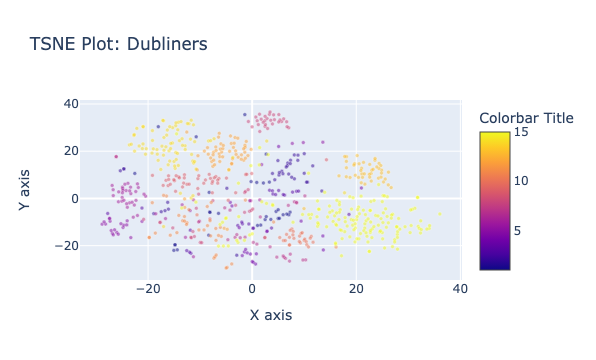

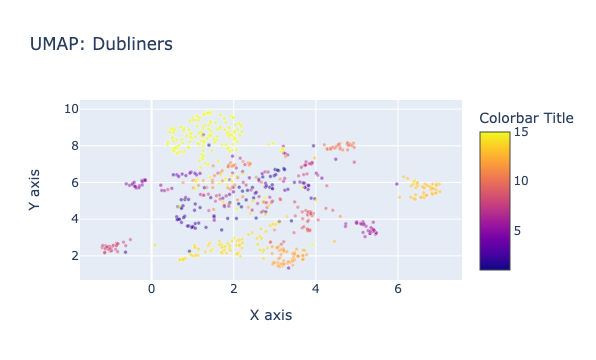

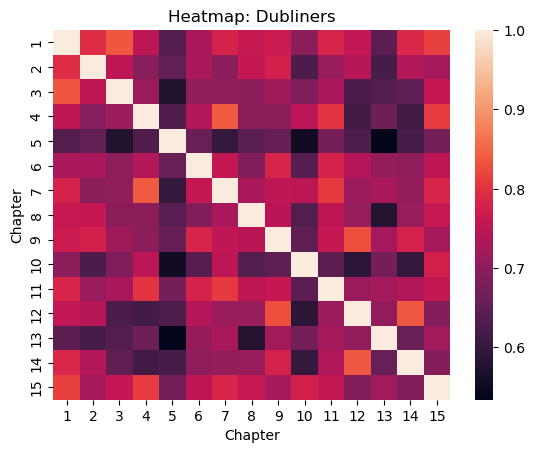

In [99]:
title='Dubliners'

tsne_plot(df_processed[title],title=title)
umap_plot(df_processed[title],title=title)
dub_heat_matrix=heatmap_plot(df_processed[title],title=title)

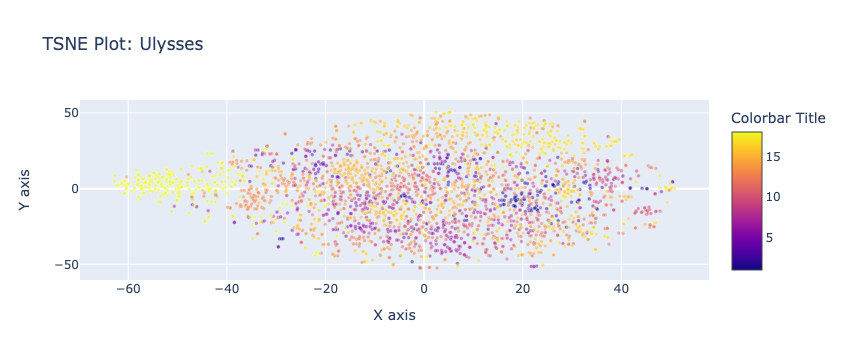

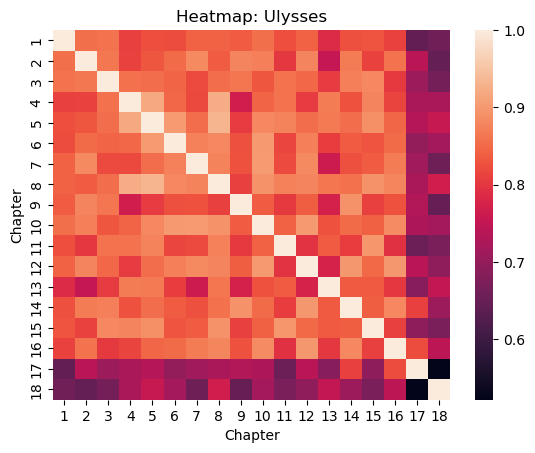

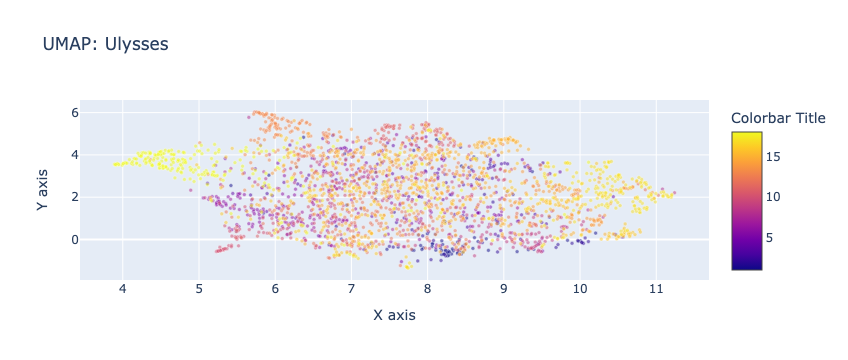

In [74]:
title='Ulysses'

tsne_plot(df_processed[title],title=title)
heatmap_plot(df_processed[title],title=title)
umap_plot(df_processed[title],title=title)

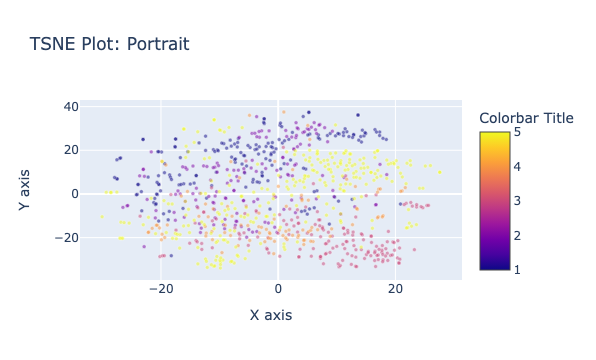

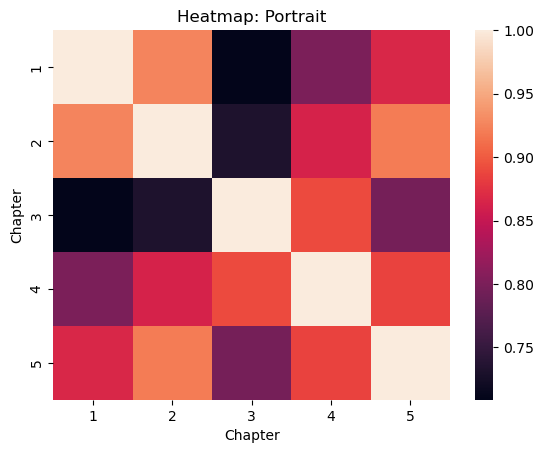

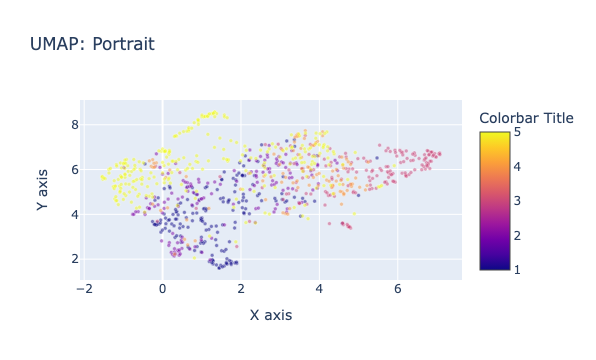

In [97]:
title='Portrait'

tsne_plot(df_processed[title],title=title)
heatmap_plot(df_processed[title],title=title)
umap_plot(df_processed[title],title=title)